In [1]:
#Linear Regression 으로 내일 종가 예측


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
url = 'http://finance.daum.net/domestic/kospi200'
url = '코스피200 _ 다음 금융.html' #웹페이지를 다른 이름으로 저장
tables = pd.read_html(url, index_col=0) # index는 일자로 한다.
len(tables)

3

In [4]:
for table in tables:
    print(table.shape)

(10, 6)
(10, 8)
(10, 7)


In [5]:
df = tables[1]

In [6]:
df.head()

,종가,전일비,등락률,거래량,거래대금,개인(억),외국인(억),기관(억)
일자,,,,,,,,
19.07.02,276.84,▼0.43,-0.16%,22664,829865,323,107,-411
19.07.01,277.27,▼0.23,-0.08%,74357,3446049,-214,1286,365
19.06.28,277.50,▼0.25,-0.09%,67598,2879563,-1802,3011,-1189
19.06.27,277.75,▲2.22,+0.81%,66303,3357666,-4165,1837,2415
19.06.26,275.53,▲0.25,+0.09%,58818,2636531,-712,157,557


In [7]:
#전일비와 등락률을 수치데이터로 변환
df['전일비'] = df['전일비'].replace('▼','-',regex=True)
df['전일비'] = df['전일비'].replace('▲','',regex=True)
##df['등락률'] = df['등락률'].replace('+','',regex=True)
df['등락률'] = df['등락률'].replace('%','',regex=True)
df['전일비'] = df['전일비'].astype(np.float)
df['등락률'] = df['등락률'].astype(np.float)

In [34]:
#min,max 정규화 [0.1]
minimum = np.min(df, axis=0)
maximum = np.max(df, axis=0)
df_norm = (df - minimum) / (maximum - minimum)

In [35]:
df

,종가,전일비,등락률,거래량,거래대금,개인(억),외국인(억),기관(억)
일자,,,,,,,,
19.07.02,276.84,-0.43,-0.16,22664,829865,323,107,-411
19.07.01,277.27,-0.23,-0.08,74357,3446049,-214,1286,365
19.06.28,277.50,-0.25,-0.09,67598,2879563,-1802,3011,-1189
19.06.27,277.75,2.22,0.81,66303,3357666,-4165,1837,2415
19.06.26,275.53,0.25,0.09,58818,2636531,-712,157,557
19.06.25,275.28,-0.30,-0.11,60506,2635188,-364,277,-12
19.06.24,275.58,0.10,0.04,55539,2235175,-978,-1048,1966
19.06.21,275.48,-0.53,-0.19,77279,3275700,538,206,-767
19.06.20,276.01,0.70,0.25,55336,2417864,-1342,-434,1762


In [36]:
#X와 y를 분리
X = df_norm.iloc[1:] #오늘 데이터 제외
y = df_norm.iloc[:-1,0] #가장 오래된 데이터와 종가 외의 컬럼 제외

In [37]:
X

,종가,전일비,등락률,거래량,거래대금,개인(억),외국인(억),기관(억)
일자,,,,,,,,
19.07.01,0.805668,0.066964,0.066667,0.946498,1.000000,0.848631,0.575018,0.431188
19.06.28,0.898785,0.062500,0.060606,0.822741,0.783469,0.528986,1.000000,0.000000
19.06.27,1.000000,0.613839,0.606061,0.799030,0.966217,0.053341,0.710766,1.000000
19.06.26,0.101215,0.174107,0.169697,0.661979,0.690573,0.748390,0.296871,0.484462
19.06.25,0.000000,0.051339,0.048485,0.692887,0.690060,0.818438,0.326435,0.326582
19.06.24,0.121457,0.140625,0.139394,0.601941,0.537160,0.694847,0.000000,0.875416
19.06.21,0.080972,0.000000,0.000000,1.000000,0.934886,1.000000,0.308943,0.117092
19.06.20,0.295547,0.274554,0.266667,0.598224,0.606991,0.621578,0.151269,0.818812
19.06.19,0.012146,1.000000,1.000000,0.861833,0.880801,0.000000,0.966741,0.775527


In [38]:
y

일자
19.07.02    0.631579
19.07.01    0.805668
19.06.28    0.898785
19.06.27    1.000000
19.06.26    0.101215
19.06.25    0.000000
19.06.24    0.121457
19.06.21    0.080972
19.06.20    0.295547
Name: 종가, dtype: float64

In [39]:
X.shape, y.shape

((9, 8), (9,))

In [40]:
# Train / Test 용 분리
from sklearn.model_selection import train_test_split
offset = 2
X_train = X[offset:]  #예전
X_test = X[:offset]   #최근
y_train = y[offset:]  #예전
y_test = y[:offset]   #최근

## X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 매일매일 데이터이기에 섞지 않는다.

In [45]:

'''
train 셋으로 Linear Regression 모델 fit
78 릿지(ridge)모델 : w 를 가능한한 작게 만드는 LinearRegression
   규제(regularization)
W 를 줄인다는 것은 Y를 예측하는 데 가능한한 모든 특성을 반영해라
Y = w1 * x1 + w2 * x2 + ..... wi*xi + b
'''
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lr = Lasso().fit(X_train, y_train)

In [46]:
lr.coef_

array([ 0.,  0.,  0.,  0.,  0., -0.,  0.,  0.])

In [47]:
#score 측정
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.0, -17.27355106455674)

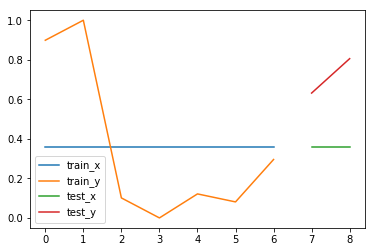

In [48]:
#예측을 그래프로 시각화
train_len = np.arange(len(X_train))
test_len = np.arange(len(X_train), len(X_train) + len(X_test))
plt.plot(train_len, lr.predict(X_train), label='train_x')
plt.plot(train_len, y_train, label='train_y')
plt.plot(test_len, lr.predict(X_test), label='test_x')
plt.plot(test_len, y_test, label='test_y')
plt.legend()